CIFAR-10数据加载及预处理

In [1]:
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() #可以把Tensor转成Image，方便可视化

#第一次运行程序torchvision会自动下载CIFAR-10数据集
#如果已经下载有CIFAR-10,可通过root参数指定

#定义对数据的预处理
transform = transforms.Compose([
    transforms.ToTensor(), #转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)), #归一化
])

#训练集

trainset = tv.datasets.CIFAR10(
                    root='F:\\python_study\\cifar-10-python\\',
                    train = True,
                    download = True,
                    transform = transform)

trainloader = t.utils.data.DataLoader(
                    trainset,
                    batch_size=4,
                    shuffle=True,
                    num_workers=2)

#测试集
testset = tv.datasets.CIFAR10(
                    'F:\\python_study\\cifar-10-python\\',
                    train = False,
                    download = True,
                    transform = transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size = 4,
                    shuffle = False,
                    num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


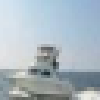

In [2]:
(data, label) = trainset[100]
print(classes[label])

#(data+1)/2 是为了还原被归一化的数据
show((data+1)/2).resize((100,100))

       bird       horse         cat        deer


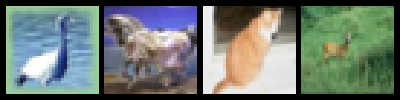

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next() #返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images + 1)/2)).resize((400,100))

定义网络

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 =  nn.Conv2d(3, 6, 5)
        self.conv2 =  nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


定义损失函数和优化器(loss和optimizer)

In [5]:
from torch import optim
criterion = nn.CrossEntropyLoss() #交叉损失函数
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

训练网络

In [6]:
from torch.autograd import Variable
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #输入数据
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        #梯度清零
        optimizer.zero_grad()
        
        #forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        #更新参数
        optimizer.step()
        
        #打印log信息
        running_loss += loss.data[0]
        if i % 2000 == 1999: #每2000个batch打印一次训练状态
            print('[%d, %5d] loss: %.3f' \
                 % (epoch + 1, i+1, running_loss /2000))
            running_loss = 0.0
        
print('Finished Training')


c:\users\darren\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  2000] loss: 2.197
[1,  4000] loss: 1.842
[1,  6000] loss: 1.655
[1,  8000] loss: 1.603
[1, 10000] loss: 1.516
[1, 12000] loss: 1.462
[2,  2000] loss: 1.392
[2,  4000] loss: 1.392
[2,  6000] loss: 1.344
[2,  8000] loss: 1.361
[2, 10000] loss: 1.290
[2, 12000] loss: 1.288
[3,  2000] loss: 1.228
[3,  4000] loss: 1.240
[3,  6000] loss: 1.193
[3,  8000] loss: 1.190
[3, 10000] loss: 1.191
[3, 12000] loss: 1.180
Finished Training


实际的label：      cat     ship     ship    plane


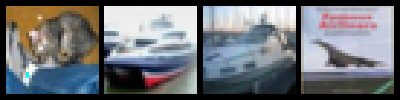

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label：', ' '.join(\
                            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images/2-0.5)).resize((400,100))

In [8]:
#计算图片在每个类别上的分数
outputs = net(Variable(images))
#得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果：', ' '.join('%5s'\
                       % classes[predicted[j]] for j in range(4)))

预测结果：   cat plane plane plane


In [9]:
correct = 0 #预测正确的图片数
total = 0 #总共的图片数
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = t.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('10000张测试集中的准确率为：%d %%'%(100*correct/total))

10000张测试集中的准确率为：54 %


在GPU上训练

In [10]:
if t.cuda.is_available():
    net.cuda()
    images = images.cuda()
    labels = labels.cuda()
    output = net(Variable(images))
    loss = criterion(output, Variable(labels))